<a href="https://colab.research.google.com/github/alxkzncoff/skillfactory_rds6_car_price_prediction_ml_dl/blob/main/model/multi_input_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSATLL

In [1]:
!pip install -q tensorflow==2.3
!pip install PyDrive
!mkdir work_dir

!pip install pymystem3

# DEFINE

In [2]:
DATA_PATH                           = '/content/work_dir'
RANDOM_SEED                         = 42

# IMPORT

In [3]:
# Data access
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# General
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import sys
import PIL
import cv2
import re
import keras

# NLP
import nltk
nltk.download('punkt')
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import codecs

# ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# KERAS
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
# Чтобы Mystem библиотека работал корректно
mystem = Mystem() 
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

--2020-11-09 14:33:16--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.242, 5.45.205.244, 5.45.205.245, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.242|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-mskm908.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2020-11-09 14:33:17--  http://cache-mskm908.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-mskm908.cdn.yandex.net (cache-mskm908.cdn.yandex.net)... 5.45.220.18, 2a02:6b8:0:2002::19
Connecting to cache-mskm908.cdn.yandex.net (cache-mskm908.cdn.yandex.net)|5.45.220.18|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz’

mystem-3.0-linux3.1 100%[===================>]  1

# DOWNLOAD DATA

In [4]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# Download clear_train.csv from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1lme9Yma6faT492hLc5RrdgS1qetNnkiq"}) # откуда берем файл
downloaded.GetContentFile(DATA_PATH+'/clear_train.csv') # куда сохраняем файл в вирутальной машине колаба

# Download clear_test.csv from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1lpC9bnDlo0LMfe8BIDRhAe8La7cwmLpd"})
downloaded.GetContentFile(DATA_PATH+'/clear_test.csv')

# Download sample_submission from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1blqFpxUkDee6fnKjpi_ISX4SUvW0A_o2"})
downloaded.GetContentFile(DATA_PATH+'/sample_submission.csv')

Чтобы не забыть:

`drive.CreateFile({'id':"file ID"})`, где file ID - это ID который можно найти в ссылке на файл. Например для сслыки **https://drive.google.com/file/d/1-3kiZxEddvuNFoRTfMA6cA8bu7LjP2b3/view?usp=sharing** ID будет `1-3kiZxEddvuNFoRTfMA6cA8bu7LjP2b3`.

Данные с которыми будешь работать лучше сразу сохранять в ВМ колаба, чтобы обработка происходила быстрее, особенно когда работаем с изображениями (строим нейроки для Computer Vision).

Как сохранять файлы хорошо расписано [тут](https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/) и [тут](https://stackoverflow.com/questions/48376580/google-colab-how-to-read-data-from-my-google-drive).

In [6]:
train = pd.read_csv(DATA_PATH+'/clear_train.csv')
test = pd.read_csv(DATA_PATH+'/clear_test.csv')
sample_submission = pd.read_csv(DATA_PATH+'/sample_submission.csv')
text_df = pd.concat([train.description, test.description])

# PREPARETION

In [7]:
def data_prep(TRAIN_DF, TEST_DF):

  # ################## Concat data ####################
  df = pd.concat([TRAIN_DF, TEST_DF])

  # ################## Tag data #####################
  df.price.fillna(0, inplace=True)
  df['sample'] = df.price.apply(lambda x:0 if x == 0 else 1)

  # ################## Prepare numeric data (Logarithm) ####################
  df.engine_displacement = df.engine_displacement.max() - np.log(df.engine_displacement)
  df.engine_power = df.engine_power.max() - np.log(df.engine_power)
  # df.model_date = df.model_date.max() - np.log(df.model_date)
  # df.production_date = df.production_date.max() - np.log(df.production_date)
  # df.days_in_use = df.days_in_use.max() - np.log(df.days_in_use)

  categorical_features = ['body', 'brand', 'color', 'fuel', 'model_info', 'name',  'num_of_doors',  'transmission', 'owners', 'vehicle_title', 'drive_type']
  numerical_features = ['engine_displacement', 'engine_power', 'mileage', 'model_date', 'production_date', 'tax', 'days_in_use']

  # ############################## Label Encoding #####################################
  for column in categorical_features:
      df[column] = df[column].astype('category').cat.codes
  
  # ############################### One Hot encoding ###################################
  df = pd.get_dummies(df, columns=categorical_features, dummy_na=False)

  # ############################### Normalization ######################################
  MMS = MinMaxScaler()

  MMS.fit(df[numerical_features])
  df[numerical_features] = MMS.transform(df[numerical_features])

  return df

In [8]:
df = data_prep(train, test)
df.head()

,description,engine_displacement,engine_power,mileage,model_date,price,production_date,tax,days_in_use,sample,body_0,body_1,body_2,body_3,body_4,body_5,body_6,body_7,body_8,body_9,body_10,body_11,body_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,...,name_337,name_338,name_339,name_340,name_341,name_342,name_343,name_344,name_345,name_346,name_347,name_348,name_349,name_350,name_351,name_352,name_353,name_354,name_355,name_356,name_357,name_358,name_359,num_of_doors_0,num_of_doors_1,num_of_doors_2,num_of_doors_3,transmission_0,transmission_1,transmission_2,transmission_3,owners_0,owners_1,owners_2,owners_3,vehicle_title_0,vehicle_title_1,drive_type_0,drive_type_1,drive_type_2
0,Авто на бодром ходу. Все работает отлично. П...,0.328812,0.423210,0.244999,0.750000,599000.0,0.657895,0.383285,0.342100,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1
1,"Продажа от собственника, второй владелец, ПТС ...",0.357585,0.552008,0.182999,0.833333,850000.0,0.763158,0.118732,0.236833,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0
2,Внимание! Только для клиентов AVILON Автомобил...,0.264526,0.370477,0.122732,0.791667,1325000.0,0.815789,0.432277,0.184163,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1
3,В комплекте зимние колёса. 27.07.2020 Замена п...,0.497904,0.608045,0.150999,0.833333,815000.0,0.763158,0.077810,0.236833,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0
4,"Отличный авто, 2011 года выпуска, кроме передн...",0.541843,0.660777,0.139999,0.750000,810000.0,0.763158,0.060519,0.236833,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0


In [9]:
text_df

0       Авто на бодром ходу.  Все работает отлично.  П...
1       Продажа от собственника, второй владелец, ПТС ...
2       Внимание! Только для клиентов AVILON Автомобил...
3       В комплекте зимние колёса. 27.07.2020 Замена п...
4       Отличный авто, 2011 года выпуска, кроме передн...
                              ...                        
1666    Продаётся любимица семьи. Автомобилем неактивн...
1667    В продаже автомобиль от компании АО ABTODOM, о...
1668    Машина в идеальном техническом состоянии. Обсл...
1669    Автомобиль приобретался новым у дилера Avilon ...
1670    ID: 38887\nКомплектация-Comfort\nГод выпуска в...
Name: description, Length: 8353, dtype: object

# TO DO LIST

1. Удалить все нерелевантные символы (например, любые символы, не относящиеся к цифро-буквенным).
2. Токенизировать текст, разделив его на индивидуальные слова.
3. Удалить нерелевантные слова — например, упоминания в Twitter или URL-ы.
4. Перевести все символы в нижний регистр для того, чтобы слова «привет», «Привет» и «ПРИВЕТ» считались одним и тем же словом.
5. Рассмотрите возможность совмещения слов, написанных с ошибками, или имеющих альтернативное написание (например, «круто»/«круть»/ «круууто»)
6. Рассмотрите возможность проведения лемматизации, т. е. сведения различных форм одного слова к словарной форме (например, «машина» вместо «машиной», «на машине», «машинах» и пр.)

# TEXT PREPARING

In [10]:
# Создаем леммитайзер и список стоп-слов
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

# Функция для лемматизации и удалении стоп-слов
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    # tokens = [token for token in tokens if token not in russian_stopwords\
    #           and token != " " \
    #           and token.strip() not in punctuation]

    tokens = [token for token in tokens if token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [11]:
text_df.iloc[303]

'Год выпуска: 2008. Пробег: 180\xa0000\xa0км. Кузов: купе. Цвет: синий. Двигатель: 1.8 л / 170\xa0л.с. / Бензин. Налог: 7\xa0650\xa0₽ / год. Коробка: вариатор. Привод: передний. Руль: Левый. Состояние: Не требует ремонта. Владельцы: 3 или более. ПТС: Дубликат. Таможня: Растаможен. VIN: WAU**************. Госномер: ******|750. '

In [14]:
text_df = text_df.apply(preprocess_text)

In [15]:
text_df.iloc[0]

'авто на бодрый ход все работать отлично по электрика ходовой акпп двс нарекание нет .. масло не есть .!!! салон уходить на запчасть деньги не жалеть жидкость все поменять красить один дверь левый задний штраф и ограничение нет ..! торг при осмотр возможный обмен на внедорожник или коммерческий транспорт'

In [16]:
def reg_exp(text):

  nums_and_chars = ' '.join(re.findall(r'\w+',text))
  chars = ''.join(re.findall(r'\D+',nums_and_chars))
  only_chars = re.sub(r'[!"#$%&\'()*+,-./:;?@[\\]^_`{|}~]', '', chars)
  final = re.sub(r'[a-z]', '', only_chars)

  return final

In [17]:
text_df = text_df.apply(reg_exp)

In [18]:
text_df.iloc[0]

'авто на бодрый ход все работать отлично по электрика ходовой акпп двс нарекание нет масло не есть салон уходить на запчасть деньги не жалеть жидкость все поменять красить один дверь левый задний штраф и ограничение нет торг при осмотр возможный обмен на внедорожник или коммерческий транспорт'

# SPLIT

In [19]:
X = df.query('sample==1').drop(columns=['description', 'price', 'sample'])
y = df.query('sample==1').price.values
test = df.query('sample==0').drop(columns=['description', 'price', 'sample'])

# ############ Split #################
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

text_train = text_df.iloc[X_train.index]
text_test = text_df.iloc[X_test.index]
text_sub = text_df.iloc[test.index]

# TOKENIZE

## Bag of words with tfidf 2-grams

In [20]:
  MAX_WORDS=100000

In [21]:
def bow_tfidf_2_grams(text, train_df, test_df, sub_df):

  tfidf_vectorizer=TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df=70, max_features=MAX_WORDS, use_idf=True, smooth_idf=True)
  tfidf_vectorizer_vectors=tfidf_vectorizer.fit(text)

  train_tfidf = tfidf_vectorizer.transform(train_df)
  test_tfidf = tfidf_vectorizer.transform(test_df)
  text_sub_tfidf = tfidf_vectorizer.transform(sub_df)

  print(train_tfidf.shape, test_tfidf.shape, text_sub_tfidf.shape, )

  text_df_transform = tfidf_vectorizer.transform(text_df)

  train=train_tfidf.todense()
  test=test_tfidf.todense()
  sub=text_sub_tfidf.todense()

  return train, test, sub, text_df_transform, tfidf_vectorizer

In [22]:
train_tfidf, test_tfidf, text_sub_tfidf, text, vocabulary = bow_tfidf_2_grams(text_df, text_train, text_test, text_sub)

(6013, 1532) (669, 1532) (1671, 1532)


In [23]:
vocabulary.get_feature_names()[500:520]

['климатический установка',
 'ключ документ',
 'ключ комплект',
 'ключ регулировка',
 'ключ электрорегулировка',
 'км автомобиль',
 'км кузов',
 'км назад',
 'книжка свидетельство',
 'кнопка система',
 'коврик знак',
 'код автомобиль',
 'код для',
 'кожа рычаг',
 'кожа черный',
 'кожаный обивка',
 'кожаный рулевой',
 'кожаный руль',
 'кожаный салон',
 'колесный болт']

In [24]:
vocabulary_size = len(vocabulary.get_feature_names())

# MODEL

In [25]:
# MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [33]:
# Один из способов вычислить необходимое количество нейронов в слоях
def num_of_nodes_compute(neurons_input, neurons_output):
  hidden_nodes = int(2/3 * (neurons_input * neurons_output))
  return hidden_nodes

lstm_nodes = num_of_nodes_compute(1532, 1)
lstm_2_nodes = num_of_nodes_compute(1021, 1)
lstm_dense_nodes = num_of_nodes_compute(680, 1)
dense_nodes = num_of_nodes_compute(542, 1)
concate_nodes = num_of_nodes_compute(451, 1)

# NLP
print('NLP:')
print(f'Numbers of nodes for LSTM layer: {lstm_nodes}')
print(f'Numbers of nodes for LSTM 2 layer: {lstm_2_nodes}')
print(f'Numbers of nodes for LSTM 2/DENSE layer: {lstm_dense_nodes}')
print(f'Numbers of nodes for concatenate layer: {concate_nodes}\n')

# MLP
print('MLP:')
print(f'Numbers of nodes for DENSE layer: {dense_nodes}')

NLP:
Numbers of nodes for LSTM layer: 1021
Numbers of nodes for LSTM 2 layer: 680
Numbers of nodes for LSTM 2/DENSE layer: 453
Numbers of nodes for concatenate layer: 300

MLP:
Numbers of nodes for DENSE layer: 361


In [29]:
def build_model(LR, EPOCHS, OPTIMIZER_TYPE):

  # ################## NLP model ####################
  model_nlp = Sequential()
  model_nlp.add(L.Input(shape=vocabulary_size, name="seq_description"))
  model_nlp.add(L.Embedding(vocabulary_size+1, 1021,))
  model_nlp.add(L.LSTM(lstm_nodes,))
  model_nlp.add(L.Dropout(0.2))
  # model_nlp.add(L.LSTM(lstm_2_nodes,))
  # model_nlp.add(L.Dropout(0.2))
  model_nlp.add(L.Dense(lstm_dense_nodes,))
  model_nlp.add(L.Activation('relu'))
  # model_nlp.add(L.Dropout(0.25))

  # ################# DENSE model ####################
  model_mlp = Sequential()
  model_mlp.add(L.Dense(dense_nodes, input_dim=X_train.shape[1]))
  model_mlp.add(L.Dropout(0.2))
  model_mlp.add(L.Activation('relu'))
  # model_mlp.add(L.Dense(545, activation="relu")
  model_mlp.add(L.Dense(1,))
  model_mlp.add(L.Activation('linear'))

  # ################# Concatenate models ######################
  combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
  head = L.Dense(concate_nodes, activation="relu")(combinedInput)
  head = L.Dense(1, activation="linear")(head)

  model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

  # ################# Show model ###################
  display(model.summary())

  plt.figure(figsize=(20,15))
  plot_model(model, to_file=DATA_PATH+'/model_plot.png', show_shapes=True, show_layer_names=True)
  img = mpimg.imread(DATA_PATH+'/model_plot.png')
  plt.imshow(img)
  plt.show()

  # ################# Optimizer #######################
  if OPTIMIZER_TYPE == 'Adam':
    optimizer = tf.keras.optimizers.Adam(LR)
  elif OPTIMIZER_TYPE == 'Adamax':
    optimizer = tf.keras.optimizers.Adamax(LR)

  model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

  # ################# Checkpoints ######################
  checkpoint = ModelCheckpoint(DATA_PATH+'/best_model.hdf5', monitor='val_MAPE', verbose=1, save_best_only=True, mode='min')
  earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
  callbacks_list = [checkpoint, earlystop]

  # ######################## Fit model ##############################
  history = model.fit([train_tfidf, X_train], y_train,
                    batch_size=128,
                    epochs=EPOCHS, 
                    validation_data=([test_tfidf, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=1
                   )

  # ######################## Show results ###########################
  plt.figure(figsize=(15,10))
  plt.title('Loss')
  plt.plot(history.history['MAPE'], label='train')
  plt.plot(history.history['val_MAPE'], label='test')
  plt.legend()
  plt.grid()
  plt.show()

  # ######################## Saving best model #####################
  model.load_weights(DATA_PATH+'/best_model.hdf5')
  model.save(DATA_PATH+'/nn_mlp_nlp.hdf5')

  test_predict_nn2 = model.predict([test_tfidf, X_test])
  print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

  return model, checkpoint, earlystop, callbacks_list, history, test_predict_nn2

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 1532)]       0                                            
__________________________________________________________________________________________________
dense_6_input (InputLayer)      [(None, 542)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1532, 1021)   1565193     seq_description[0][0]            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 361)          196023      dense_6_input[0][0]              
_______________________________________________________________________________________

None

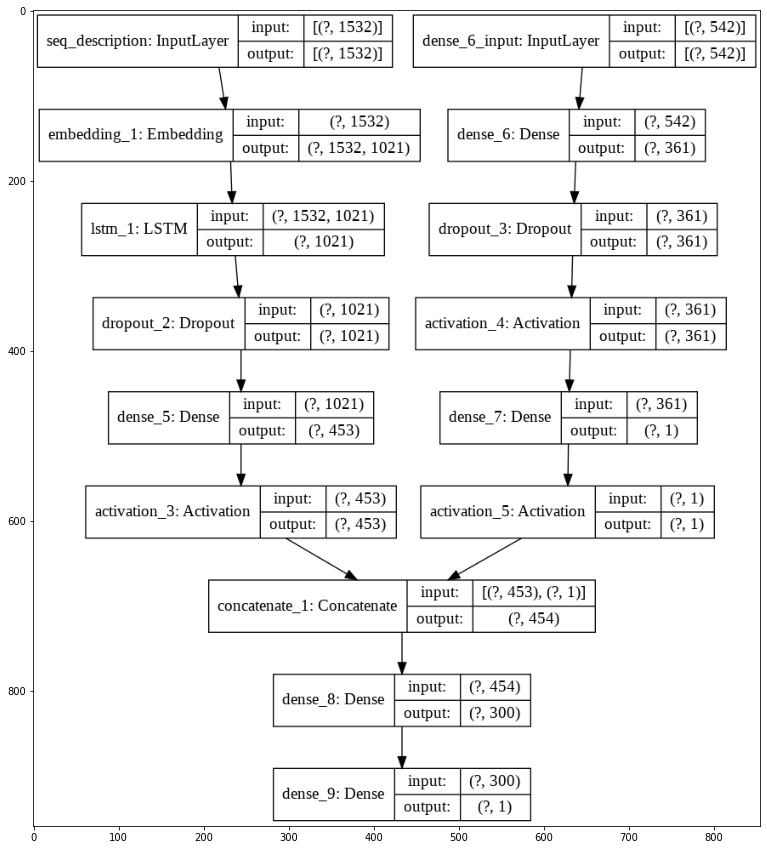

Epoch 1/500
47/47 [==============================] - ETA: 0s - loss: 56.9020 - MAPE: 56.9020
Epoch 00001: val_MAPE improved from inf to 48.94583, saving model to /content/work_dir/best_model.hdf5
47/47 [==============================] - 145s 3s/step - loss: 56.9020 - MAPE: 56.9020 - val_loss: 48.9458 - val_MAPE: 48.9458
Epoch 2/500
47/47 [==============================] - ETA: 0s - loss: 38.1264 - MAPE: 38.1264
Epoch 00002: val_MAPE improved from 48.94583 to 30.90224, saving model to /content/work_dir/best_model.hdf5
47/47 [==============================] - 147s 3s/step - loss: 38.1264 - MAPE: 38.1264 - val_loss: 30.9022 - val_MAPE: 30.9022
Epoch 3/500
47/47 [==============================] - ETA: 0s - loss: 29.5744 - MAPE: 29.5744
Epoch 00003: val_MAPE improved from 30.90224 to 26.19378, saving model to /content/work_dir/best_model.hdf5
47/47 [==============================] - 147s 3s/step - loss: 29.5744 - MAPE: 29.5744 - val_loss: 26.1938 - val_MAPE: 26.1938
Epoch 4/500
47/47 [=====

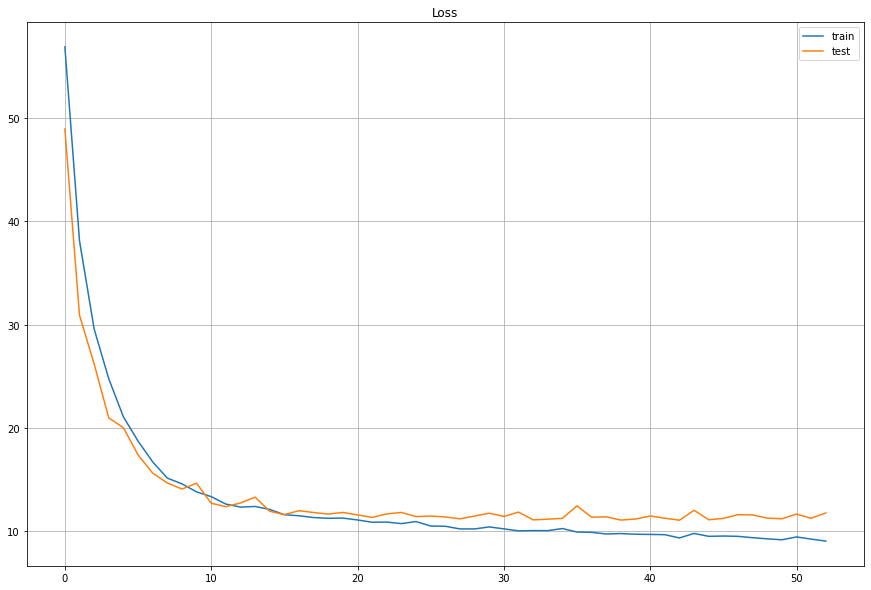

TEST mape: 11.05%


In [34]:
model, checkpoint, earlystop, callbacks_list, history, test_predict_nn2 = build_model(LR=0.1, EPOCHS=500, OPTIMIZER_TYPE='Adamax')

# PREDICT

In [35]:
predict_submission = model.predict([text_sub_tfidf, test])

sample_submission['price'] = predict_submission
sample_submission.to_csv(DATA_PATH+f'/sub_nn2_{round((mape(y_test, test_predict_nn2[:,0])*100),2)}.csv'.replace('.', '_', 1), index=False)
display(sample_submission.head(10))

,sell_id,price
0,1099427284,3.701422e+05
1,1096405886,2.551614e+06
2,1100195294,6.505458e+05
3,1099827282,4.942738e+05
4,1100076198,2.609224e+06
5,1090159352,2.946458e+06
6,1098987386,1.725602e+06
7,1098639040,1.548938e+06
8,1099933039,1.220194e+06
9,1099565572,5.319114e+05
